## Dwarf galaxy discovery metric ##

In [11]:
import os
import numpy as np
import healpy as hp
from astropy.coordinates import SkyCoord
from astropy.io import fits, ascii
import astropy.units as u
import matplotlib.pyplot as plt
%matplotlib inline   
# %matplotlib notebook

In [12]:
# Import MAF
import rubin_sim.maf as maf
from rubin_sim.data import get_baseline

THIS CELL SHOULD DESCRIBE THE METRIC(S) AND THE PROCESS OF CALCULATING THEM.

### Methodology for Local Volume galaxies' dwarf satellites:
We use the latest tables from the [Local Volume Galaxies Database](http://www.sao.ru/lv/lvgdb/]) (based on Karachentsev et al. 2013), limiting our selection to Dec < 35 deg. We calculate the stellar mass of all galaxies using their total K−band luminosities, assuming mass-to-light of 1.0 in K. We then limit the sample to galaxies with $M_{star} > 10^7 M_{Sun}$ (removing the faintest systems, which will not be expected to have significant dwarf satellite populations; e.g., Dooley et al. 2017b,a); this leaves a total of 302 galaxies between 1.3 < D < 9 Mpc (of which 139 are within 6 Mpc).

The metric is evaluated at the positions of known galaxies by defining a custom `UserPointSlicer` object with the positions and distances to galaxies from the catalog described above. The function that creates this slicer is called `generateKnownLVDwarfSlicer`. (Note, however, that the metric can be calculated with a healpix map and a fixed distance limit; see below for more on this method.)

To estimate the detectability of dwarf satellites, we begin by considering the unresolved background galaxies and foreground Milky Way stars that contaminate a CMD selection of candidate RGB stars. For each of the galaxies in our sample, we extract the expected number of galaxies per square arcmin using the **GalaxyCountsMetric**, and the expected stellar density from the **StarDensityMetric**. We apply a scaling factor (`cmd_frac`=0.1 by default) to account for the sub-region of the CMD inhabited by our tracers (RGB stars) relative to the full-CMD area spanned by the simulations, and an additional scaling factor to account for unresolved galaxy contamination (`stargal_contamination`=0.4 by default) in a stellar sample selection at the faint end. Then, with an estimated number of contaminants, we calculate the number of stars required to be detected to reach a given Poisson-limited signal-to-noise (S/N > 10 by default). For the region around each Local Volume galaxy, we use a function called `makeFakeLF` which reads in a [PARSEC](http://stev.oapd.inaf.it/cgi-bin/cmd) luminosity function for an old (10 Gyr), metal-poor (\[M/H\] = −1.5) population and generates fake dwarf galaxies using a simulated luminosity function (in g and i bands). We generate dwarfs with known luminosities, continuing to fainter luminosities until we reach the S/N threshold. Our final figure of merit (FoM) is the number of Local Volume galaxies for which the faintest detectable dwarf satellite galaxy is fainter than our chosen dwarf luminosity threshold ($M_V = −7$).

You need to connect to the opsim output, so let's do that first. <br>
It's easy to use the current baseline simulation included with $RUBIN_SIM_DATA_DIR, so let's start with that.

In [13]:
opsim_fname = get_baseline()
print(opsim_fname)

runName = os.path.split(opsim_fname)[-1].replace('.db', '')
print(runName)

/sims_maf/rubin_sim_data/sim_baseline/baseline_v2.0_10yrs.db
baseline_v2.0_10yrs


In [14]:
# Connect to the database so we can use it with MAF.
opsim_db = maf.OpsimDatabase(opsim_fname)

And let's set up a slicer that will give us the observations that overlap a single point on the sky.

In [15]:
def generateKnownLVDwarfSlicer():
    """Generate a population of KNe events, and put the info about them
    into a UserPointSlicer object
    """

    # path = '/dlusers/jcarlin/rubin_sim_data/maf/LVDwarfs_data/'
    path = '/dlusers/jcarlin/sims_maf/SMWLV-metrics/notebooks/'
    lv_dat0 = fits.getdata(path+'lsst_galaxies_1p25to9Mpc_table.fits')

    # Keep only galaxies at dec < 35 deg., and with stellar masses > 10^7 M_Sun (and <1e14).
    lv_dat_cuts = (lv_dat0['dec'] < 35.0) & (lv_dat0['MStars'] > 1e7) & (lv_dat0['MStars'] < 1e14)
    lv_dat = lv_dat0[lv_dat_cuts]

    # Set up the slicer to evaluate the catalog we just made
    slicer = maf.UserPointsSlicer(lv_dat['ra'], lv_dat['dec'], latLonDeg=True, badval=-666)
    # Add any additional information about each object to the slicer
    slicer.slicePoints["distance"] = lv_dat['dist_Mpc']

    return slicer

In [16]:
# lv_slicer = maf.mafContrib.generateKnownLVDwarfSlicer()
lv_slicer = generateKnownLVDwarfSlicer()

Now set up to work with our Metric. Remember that the Metric will work on a single DataSlice at a time -- so 
*all* of (and *only*) the observation information it receives will be the visits relevant to this test_ra/test_dec location.

In [50]:
# lf_dict_g, lf_dict_i = maf.mafContrib.make_LF_dicts()
lf_dict_g, lf_dict_i = make_LF_dicts()

In [33]:
class LVDwarfsMetric(maf.BaseMetric):
    """Documentation please. Numpy style docstrings. 
    
    This example metric just finds the time of first observation of a particular part of the sky.
    
    Parameters
    ----------
    specificColumns : `str`, opt
        It's nice to be flexible about what the relevant columns are called, so specify them here.
        seeingCol = FWHMeff, etc. 
    kwargs : `float`, ? 
        Probably there are other things you need to set?
    """
    # def __init__(self, nside=16, cmd_frac=0.1, stargal_contamination=0.40, nsigma=10.0, **kwargs):
    def __init__(self, radius=2.45, distlim=None, cmd_frac=0.1, stargal_contamination=0.40, nsigma=10.0, **kwargs):
        # maps = ["CoaddM5"]
        # self.mjdCol = mjdCol
        # self.nside = nside
        self.radius = radius
        self.filterCol = "filter"
        self.m5Col = "fiveSigmaDepth"
        self.cmd_frac = cmd_frac
        self.stargal_contamination = stargal_contamination
        self.nsigma = nsigma

        if distlim is not None:
            self.distlim = distlim
        else:
            self.distlim = None
            # path = '/dlusers/jcarlin/rubin_sim_data/maf/LVDwarfs_data/'
            path = '/dlusers/jcarlin/sims_maf/SMWLV-metrics/notebooks/'
            lv_dat0 = fits.getdata(path+'lsst_galaxies_1p25to9Mpc_table.fits')
            # Keep only galaxies at dec < 35 deg., and with stellar masses > 10^7 M_Sun.
            lv_dat_cuts = (lv_dat0['dec'] < 35.0) & (lv_dat0['MStars'] > 1e7) & (lv_dat0['MStars'] < 1e14)
            lv_dat = lv_dat0[lv_dat_cuts]
            sc_dat = SkyCoord(ra=lv_dat['ra']*u.deg, dec=lv_dat['dec']*u.deg, distance=lv_dat['dist_Mpc']*u.Mpc)
            self.sc_dat = sc_dat
        
        self.Coaddm5Metric = maf.simpleMetrics.Coaddm5Metric(m5Col=self.m5Col)
        self.StarDensityMetric24 = maf.starDensity.StarDensityMetric(rmagLimit=24)
        self.StarDensityMetric24p5 = maf.starDensity.StarDensityMetric(rmagLimit=24.5)
        self.StarDensityMetric25 = maf.starDensity.StarDensityMetric(rmagLimit=25)
        self.StarDensityMetric25p5 = maf.starDensity.StarDensityMetric(rmagLimit=25.5)
        self.StarDensityMetric26 = maf.starDensity.StarDensityMetric(rmagLimit=26)
        self.StarDensityMetric26p5 = maf.starDensity.StarDensityMetric(rmagLimit=26.5)
        self.StarDensityMetric27 = maf.starDensity.StarDensityMetric(rmagLimit=27)
        self.GalaxyCountsMetric = maf.mafContrib.LSSObsStrategy.galaxyCountsMetric_extended.GalaxyCountsMetric_extended(m5Col=self.m5Col)
        # self.GalaxyCountsMetric = maf.mafContrib.LSSObsStrategy.galaxyCountsMetric_extended.GalaxyCountsMetric_extended(m5Col=self.m5Col, nside=self.nside)
        cols = [self.m5Col, self.filterCol] # Add any columns that your metric needs to run -- mjdCol is just an example
        maps = ['DustMap', 'StellarDensityMap']
        super().__init__(col=cols, maps=maps, units='#', **kwargs)
        
    def run(self, dataSlice, slicePoint=None):
        # This is where you write what your metric does. 
        # dataSlice == the numpy recarray containing the pointing information, 
        # with the columns that you said you needed in 'cols'
        # slicePoint == the information about where you're evaluating this on the sky -- ra/dec,
        # and if you specified that you need a dustmap or stellar density map, etc., those values will also 
        # be defined here
        
        # here's a super simple example .. replace with your own code to calculate your metric values
        # tMin = dataSlice[self.mjdCol].min()
        rband = (dataSlice[self.filterCol] == 'r')
        gband = (dataSlice[self.filterCol] == 'g')
        iband = (dataSlice[self.filterCol] == 'i')
        r5 = self.Coaddm5Metric.run(dataSlice[rband])
        g5 = self.Coaddm5Metric.run(dataSlice[gband])
        i5 = self.Coaddm5Metric.run(dataSlice[iband])
        nstar24 = self.StarDensityMetric24.run(dataSlice, slicePoint)
        nstar24p5 = self.StarDensityMetric24p5.run(dataSlice, slicePoint)
        nstar25 = self.StarDensityMetric25.run(dataSlice, slicePoint)
        nstar25p5 = self.StarDensityMetric25p5.run(dataSlice, slicePoint)
        nstar26 = self.StarDensityMetric26.run(dataSlice, slicePoint)
        nstar26p5 = self.StarDensityMetric26p5.run(dataSlice, slicePoint)
        nstar27 = self.StarDensityMetric27.run(dataSlice, slicePoint)
        nstar = nstar27

        # import pdb; pdb.set_trace()
       
        if 'nside' in slicePoint.keys():
            nside = slicePoint['nside']
            try:
                ngal = self.GalaxyCountsMetric.run(dataSlice, slicePoint, nside=nside)
            except:
                ngal = 1e7
                # print('healpix ',slicePoint['sid'], 'failed in GalaxyCountsMetric')
        else:
            ngal = self.GalaxyCountsMetric.run(dataSlice, slicePoint)

            
        # print(dataSlice)
        nstar_all = nstar*0.0
        rbinvals = np.arange(24.0, 27.5, 0.5)
        rbinlimits = [nstar24, nstar24p5, nstar25, nstar25p5, nstar26, nstar26p5, nstar27]

        # Star density is number of stars per square arcsec.
        # Convert to a total number per healpix, then number per sq. arcmin:
        # First, get the slicer pixel area.
        # import pdb; pdb.set_trace()

        '''
        # Is this correct? How do I ensure that the metrics are using this healpix scale?
        nside = self.nside

        # Calculate the factor to go from number per healpix to number per square arcminute or per square arcsec
        pixarea_deg = hp.nside2pixarea(nside, degrees=True)*(u.degree**2)
        pixarea_arcmin = pixarea_deg.to(u.arcmin**2)
        pixarea_arcsec = pixarea_deg.to(u.arcsec**2)
        
        nstar_all_per_healpix = nstar_all*pixarea_arcsec.value
        nstar_all_per_arcmin = nstar_all_per_healpix/pixarea_arcmin.value

        # Number of galaxies is the total in each healpix. Convert to number per sq. arcmin:
        ngal_per_arcmin = ngal/pixarea_arcmin.value

        # Star density is number of stars per square arcsec.
        # Convert to a total number per healpix, then number per sq. arcmin:
        nstar_per_healpix = nstar*pixarea_arcsec.value
        nstar_per_arcmin = nstar_per_healpix/pixarea_arcmin.value
        '''
        
        nstar0 = rbinlimits[np.argmin(np.abs(rbinvals-r5))]
        
        if 'nside' in slicePoint.keys():
            nside = slicePoint['nside']
            # Calculate the factor to go from number per healpix to number per square arcminute or per square arcsec
            area_deg = hp.nside2pixarea(nside, degrees=True)*(u.degree**2)
            area_arcmin = area_deg.to(u.arcmin**2)
            area_arcsec = area_deg.to(u.arcsec**2)
        else:
            area_arcsec = np.pi*((self.radius*u.deg).to(u.arcsec)**2)
            area_arcmin = np.pi*((self.radius*u.deg).to(u.arcmin)**2)

        nstar_all = nstar0*area_arcsec.value

        ngal_per_arcmin = ngal/area_arcmin.value
        nstar_all_per_arcmin = nstar_all/area_arcmin.value
        # print(ngal, nstar_all, r5, nstar_all_per_arcmin, ngal_per_arcmin)

        nstars_required = self.nsigma*np.sqrt(ngal_per_arcmin*(self.cmd_frac*self.stargal_contamination)+(nstar_all_per_arcmin*self.cmd_frac))
        
        # Add a check so that if healpix slicer is used, distlim is also ***required***
        if self.distlim is not None:
            distlim = self.distlim
        else:
            distlim = slicePoint['distance']*u.Mpc
            # sc_slice = SkyCoord(ra=slicePoint['ra']*u.rad, dec=slicePoint['dec']*u.rad)
            # seps = sc_slice.separation(self.sc_dat)
            # distlim = self.sc_dat[seps.argmin()].distance

        mg_lim, mi_lim, sb_g_lim, sb_i_lim, flag_lim = sblimit(g5, i5, nstars_required, distlim=distlim.value)

        # Use the conversion from Appendix A of Komiyama+2018, ApJ, 853, 29:
        # V = g_hsc - 0.371*(gi_hsc)-0.068
        mv = mg_lim - 0.371 * (mg_lim - mi_lim) - 0.068
        # sbv = sb_g_lim - 0.371 * (sb_g_lim - sb_i_lim) - 0.068

        # If the distance limit is outside the reachable range, set mv to "badval"
        if (np.abs(mv) > 20) or np.isnan(mv):
            mv = self.badval
        # import pdb; pdb.set_trace()

        return mv
# When you re-run this cell, you may get a warning that the metric name already exists - that's ok! 

The typical way to use this metric with a slicer within MAF would be as follows: 

In [66]:
# Set up the metric
# mymetric = maf.mafContrib.LVDwarfsMetric() # for the discrete LV galaxies
# mymetric = maf.mafContrib.LVDwarfsMetric(distlim=0.05*u.Mpc) # for a distance limit, healpix map

# mymetric = LVDwarfsMetric() # for the discrete LV galaxies
mymetric = LVDwarfsMetric(distlim=0.3*u.Mpc) # for a distance limit, healpix map

In [67]:
# Define a sqlconstraint, if we need to just use a (large) subset of the opsim visits
# sqlconstraint = 'filter = "r"'   # no constraint, make all visits available
sqlconstraint = '(filter = "r" OR filter = "i" OR filter = "g")'   # no constraint, make all visits available
# sqlconstraint = None   # no constraint, make all visits available

# Examples of other potentially useful sqlconstraints:
# sqlconstraint = 'filter = "r"'  # just select the visits in a particular filter
# sqlconstraint = 'note not like "%DD%"'  # don't choose any of the DD field visits
# sqlconstraint = 'night < 365'  # only use visits in the first year of the survey

In [68]:
# We already defined the slicer - combine the metric, slicer and sqlconstraint in a MetricBundle:
# bundle = maf.MetricBundle(mymetric, test_slicer, sqlconstraint, runName=runName)
# bundle = maf.MetricBundle(mymetric, lv_slicer, sqlconstraint, runName=runName)

# lv_slicer = maf.UserPointsSlicer(lv_dat['ra'], lv_dat['dec'])

test_slicer = maf.HealpixSlicer(nside=16)
bundle = maf.MetricBundle(mymetric, test_slicer, sqlconstraint, runName=runName)


Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes


In [ ]:
# Pass the bundle (along with any other bundles to be run on this opsim) to a MetricBundleGroup in order to
# calculate the metric bundle values.
g = maf.MetricBundleGroup({'test_metric': bundle}, opsim_db, outDir='test', resultsDb=None)
# And calculate the metric
g.runAll()

Querying database observations with constraint (filter = "r" OR filter = "i" OR filter = "g") for columns ['filter', 'rotSkyPos', 'fieldDec', 'fiveSigmaDepth', 'fieldRA']


And then you can look at the `bundle.metricValues` to see what your metric calculated and how well things worked.

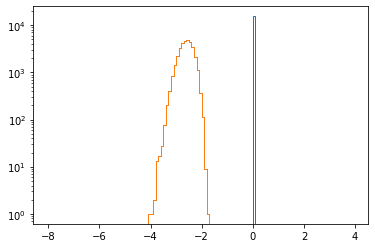

In [65]:
plt.hist(bundle.metricValues.data, bins=np.arange(-8, 4, 0.1), log=True, histtype='step')
plt.hist(bundle.metricValues.data[bundle.metricValues.mask == False], bins=np.arange(-8, 4, 0.1), log=True, histtype='step')
plt.show()

In [42]:
ok_mv = (bundle.metricValues.data < -0.5) & (bundle.metricValues.data > -5) & (bundle.metricValues.mask == False)
# print(np.sum(ok_mv)/len(bundle.metricValues.data), np.sum(ok_mv))
print(np.sum(ok_mv)/len(bundle.metricValues.data[(bundle.metricValues.mask == False)]), np.sum(ok_mv))

0.4489795918367347 44


BUT, when you're testing a new metric, you might run this many times over .. and querying the database each time is not necessary, if you are re-using the same columns from the database. If you're re-using exactly the same data (same columns, same sqlconstraint), you can skip the query like this:

In [85]:
# See new bundle metric values
# bundle.metricValues[bundle.metricValues.mask == True].fill(1111.1)
bundle.metricValues

masked_array(data=[--, -3.6135660071218707, --, -5.904419283923157,
                   -2.523451726450029, -4.807962759070298, --,
                   -4.0539481645795705, -4.747011781109957,
                   -3.1830408740564824, -3.561617260050323,
                   -3.4560458465171284, -3.8576535684282187,
                   -3.1250944483594973, --, --, --, --,
                   -2.810137928419676, --, --, --, -4.541675593199024, --,
                   --, --, --, --, --, --, -3.2102979510061553,
                   -5.1409614075615835, --, -6.5186254770562995, --, --,
                   --, --, -6.021095876153222, -4.836851828025997,
                   -5.074044704890024, --, -4.4987808898314645, --,
                   -5.5714418366829195, --, --, --, -6.355565267425202,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, -4.489140276780067, -5.719655892072657,
                   --, --, --, --, -5.151709043863397, --, --, 

In [54]:
summary1 = maf.FracAboveMetric(col='data', cutoff=-7.0)
summary2 = maf.FracBelowMetric(col='data', cutoff=-0.5)
bundle.setSummaryMetrics([summary1, summary2])
bundle.computeSummaryStats()
bundle.summaryValues
# This doesn't work, because we need to also be able to set MV<0 and mask==False. How do you combine them?

{'FracAbove -7.00 in data': 1.0, 'FracBelow -0.50 data': 1.0}

0.0 180.0 -180.0 180.0


{'SkyMap': 1, 'Histogram': 2}

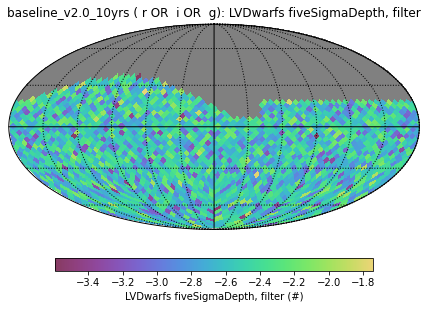

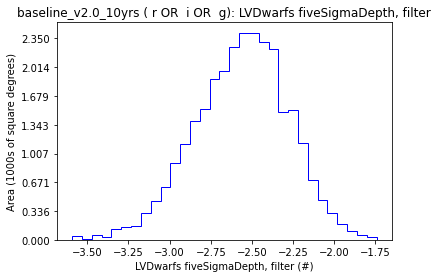

In [55]:
bundle.setPlotDict({'maskAbove':-0.5})
bundle.plot()


In [75]:
maf.

Signature: bundle.computeSummaryStats(resultsDb=None)
Docstring:
Compute summary statistics on metricValues, using summaryMetrics (metricbundle list).

Parameters
----------
resultsDb : Optional[ResultsDb]
    ResultsDb object to use to store the summary statistic values on disk.
File:      /data0/sw/lsst_stack-2021.10.13/rubin_sim/rubin_sim/maf/metricBundles/metricBundle.py
Type:      method


In [27]:
def makeFakeLF(intB, mu, filtername):
    if (filtername == 'y'):
        filtername == 'Y'
    modelBmag = 6.856379  # integrated B mag of the model LF being read
    # path = '/dlusers/jcarlin/rubin_sim_data/maf/LVDwarfs_data/'
    path = '/dlusers/jcarlin/sims_maf/SMWLV-metrics/notebooks/'
    LF = ascii.read(path+'LF_-1.5_10Gyr.dat', header_start=12)
    mags = LF['magbinc']
    counts = LF[filtername+'mag']
    # shift model LF to requested distance and dim it
    mags = mags + mu
    modelBmag = modelBmag + mu
    # scale model counts up/down to reach the requested intB
    factor = np.power(10.0, -0.4*(intB-modelBmag))
    counts = factor * counts
    return mags, counts

In [43]:
def make_LF_dicts():
    lf_dict_i = {}
    lf_dict_g = {}
    tmp_MB = -10.0

    for i in range(131):
        mbkey = f'MB{tmp_MB:.2f}'
        iLFmags, iLFcounts = makeFakeLF(tmp_MB, 0.0, 'i')
        lf_dict_i[mbkey] = (np.array(iLFmags), np.array(iLFcounts))
        gLFmags, gLFcounts = makeFakeLF(tmp_MB, 0.0, 'g')
        lf_dict_g[mbkey] = (np.array(gLFmags), np.array(gLFcounts))
        tmp_MB += 0.1

    return lf_dict_g, lf_dict_i

In [29]:
def sum_luminosity(LFmags, LFcounts):
    magref = LFmags[0]
    totlum = 0.0

    for mag, count in zip(LFmags, LFcounts):
        tmpmags = np.repeat(mag, count)
        totlum += np.sum(10.0**((magref - tmpmags)/2.5))

    mtot = magref-2.5*np.log10(totlum)
    return mtot

In [30]:
def sblimit(glim, ilim, nstars, distlim):
    distance_limit = distlim*1e6  # distance limit in parsecs
    distmod_lim = 5.0*np.log10(distance_limit) - 5.0
    
    if (glim > 15) and (ilim > 15):
        # print(glim, ilim, nstars)
        fake_MB = -10.0
        ng = 1e6
        ni = 1e6

        while (ng > nstars) and (ni > nstars) and fake_MB < -2.0:
            # B_fake = distmod_limit+fake_MB
            mbkey = f'MB{fake_MB:.2f}'
            iLFmags0, iLFcounts0 = lf_dict_i[mbkey]
            gLFmags0, gLFcounts0 = lf_dict_g[mbkey]
            iLFcounts = np.random.poisson(iLFcounts0)
            gLFcounts = np.random.poisson(gLFcounts0)
            iLFmags = iLFmags0+distmod_lim  # Add the distance modulus to make it apparent mags
            gLFmags = gLFmags0+distmod_lim  # Add the distance modulus to make it apparent mags
            # print(iLFcounts0-iLFcounts)
            gsel = (gLFmags <= glim)
            isel = (iLFmags <= ilim)
            ng = np.sum(gLFcounts[gsel])
            ni = np.sum(iLFcounts[isel])
            # print('fake_MB: ',fake_MB, ' ng: ',ng, ' ni: ', ni, ' nstars: ', nstars)
            fake_MB += 0.1

        if fake_MB > -9.9:
            gmag_tot = sum_luminosity(gLFmags[gsel], gLFcounts[gsel]) - distmod_lim
            imag_tot = sum_luminosity(iLFmags[isel], iLFcounts[isel]) - distmod_lim
            # S = m + 2.5logA, where in this case things are in sq. arcmin, so A = 1 arcmin^2 = 3600 arcsec^2
            sbtot_g = distmod_lim + gmag_tot + 2.5*np.log10(3600.0)
            sbtot_i = distmod_lim + imag_tot + 2.5*np.log10(3600.0)
            mg_lim = gmag_tot
            mi_lim = imag_tot
            sbg_lim = sbtot_g
            sbi_lim = sbtot_i
            if (ng < ni):
                flag_lim = 'g'
            else:
                flag_lim = 'i'
        else:
            mg_lim= 999.9
            mi_lim = 999.9
            sbg_lim = 999.9
            sbi_lim = 999.9
            flag_lim = 'none'
    else:
        mg_lim = 999.9
        mi_lim = 999.9
        sbg_lim = -999.9
        sbi_lim = -999.9
        flag_lim = 'none'

    return mg_lim, mi_lim, sbg_lim, sbi_lim, flag_lim

In [27]:
from astropy.io import fits, ascii

lf_dict_g, lf_dict_i = make_LF_dicts()

lv_dat0 = fits.getdata('lsst_galaxies_1p25to9Mpc_table.fits')

# Keep only galaxies at dec < 35 deg., and with stellar masses > 10^7 M_Sun.

lv_dat_cuts = (lv_dat0['dec'] < 35.0) & (lv_dat0['MStars'] > 1e7) & (lv_dat0['MStars'] < 1e14)
lv_dat = lv_dat0[lv_dat_cuts]

lv_slicer = maf.UserPointsSlicer(lv_dat['ra'], lv_dat['dec'])

In [44]:
maf.UserPointsSlicer?

Init signature:
maf.UserPointsSlicer(
    ra,
    dec,
    lonCol='fieldRA',
    latCol='fieldDec',
    latLonDeg=True,
    verbose=True,
    badval=-666,
    leafsize=100,
    radius=2.45,
    useCamera=True,
    cameraFootprintFile=None,
    rotSkyPosColName='rotSkyPos',
)
Docstring:     
A spatial slicer that evaluates pointings overlapping user-provided list of points.

Parameters
----------
ra : `list` or `numpy.ndarray`
    User-selected RA points, in degrees. Stored internally in radians.
dec : `list` or `numpy.ndarray`
    User-selected Dec points, in degrees. Stored internally in radians.
lonCol : `str`, optional
    Name of the longitude (RA equivalent) column to use from the input data.
    Default fieldRA
latCol : `str`, optional
    Name of the latitude (Dec equivalent) column to use from the input data.
    Default fieldDec
latLonDeg : `bool`, optional
    Flag indicating whether the lon and lat values will be in degrees (True) or radians (False).
    Default True (approp